In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

In [14]:
if not os.path.exists('results'):
    os.makedirs('results')
    print("Created 'results' folder to save outputs")

# 3-3-1. 数据加载


In [15]:
def load_data():
    try:
        # 读取合并后的房价/租金数据
        housing_df = pd.read_csv('Housing_Price.csv')
        rent_df = pd.read_csv('Rent_Price.csv')
        
        # 数据基本校验
        assert '总价' in housing_df.columns and 'Block' in housing_df.columns, "Housing_Price.csv missing required columns"
        assert '月租' in rent_df.columns and '每平米月租' in rent_df.columns, "Rent_Price.csv missing required columns"
        
        print(f"Data loaded successfully!")
        print(f"- Housing data shape: {housing_df.shape} (4 blocks, {housing_df['Block'].nunique()} unique)")
        print(f"- Rent data shape: {rent_df.shape} (4 blocks, {rent_df['Block'].nunique()} unique)")
        return housing_df, rent_df
    
    except FileNotFoundError as e:
        print(f"❌ Error: File not found - {e}")
        raise
    except Exception as e:
        print(f"❌ Data load failed: {e}")
        raise
    

housing_data, rent_data = load_data()

Data loaded successfully!
- Housing data shape: (4800, 4) (4 blocks, 4 unique)
- Rent data shape: (4311, 4) (4 blocks, 4 unique)


# 3-3-2. 数据描述与异常值检测


In [16]:
def detect_outliers(df, column, threshold=3):
    """使用Z-score检测异常值，返回异常值DataFrame"""
    series = df[column].dropna()
    z_scores = np.abs(stats.zscore(series))
    outlier_indices = series.index[z_scores > threshold]
    return df.loc[outlier_indices]

def analyze_data(housing_df, rent_df):
    print("\n===== Step 1: Data Description & Outlier Detection =====")
    
    # 1.1 描述性统计（保存为CSV）
    housing_stats = housing_df[['总价', '单价', '面积']].describe().round(2)
    rent_stats = rent_df[['月租', '面积', '每平米月租']].describe().round(2)
    
    housing_stats.to_csv('results/housing_descriptive_stats.csv')
    rent_stats.to_csv('results/rent_descriptive_stats.csv')
    
    print("\n Housing Price Statistics (RMB):")
    print(housing_stats)
    print("\n Rent Statistics (RMB):")
    print(rent_stats)
    
    # 1.2 异常值检测（按区域统计）
    blocks = housing_df['Block'].unique()
    outlier_summary = []
    
    for block in blocks:
        # 筛选区域数据
        h_block = housing_df[housing_df['Block'] == block]
        r_block = rent_df[rent_df['Block'] == block]
        
        # 检测异常值
        h_outliers = detect_outliers(h_block, '总价')
        r_outliers = detect_outliers(r_block, '月租')
        
        # 保存区域异常值
        h_outliers.to_csv(f'results/housing_outliers_{block}.csv', index=False)
        r_outliers.to_csv(f'results/rent_outliers_{block}.csv', index=False)
        
        # 汇总异常值数量
        outlier_summary.append({
            'Block': block,
            'Housing_Outliers (Total Price)': len(h_outliers),
            'Rent_Outliers (Monthly)': len(r_outliers),
            'Housing_Samples': len(h_block),
            'Rent_Samples': len(r_block)
        })
    
    # 打印异常值汇总
    outlier_df = pd.DataFrame(outlier_summary)
    print("\n Outlier Summary by Block:")
    print(outlier_df)
    outlier_df.to_csv('results/outlier_summary.csv', index=False)
    
    
    
analyze_data(housing_data, rent_data)


===== Step 1: Data Description & Outlier Detection =====

 Housing Price Statistics (RMB):
                总价         单价       面积
count      4800.00    4800.00  4800.00
mean    3958744.71   27767.08   116.09
std     5418569.74   23322.86    59.36
min      120000.00    2633.00    28.00
25%      850000.00    9643.00    84.48
50%     1800000.00   20104.00    94.54
75%     5000000.00   37897.00   129.43
max    65000000.00  195195.00   632.47

 Rent Statistics (RMB):
              月租       面积    每平米月租
count    4311.00  4311.00  4311.00
mean     7458.01   121.46    44.09
std     33023.77   197.06    36.16
min       400.00     7.00     3.85
25%      1450.00    80.00    17.57
50%      2550.00    91.00    29.23
75%      6800.00   125.00    63.26
max    700000.00  4193.00   300.30

 Outlier Summary by Block:
      Block  Housing_Outliers (Total Price)  Rent_Outliers (Monthly)  \
0   dachang                              23                       18   
1  majuqiao                              10  

# 3-3-3. 各区域每平米价格与租金计算


In [17]:
def calculate_per_sqm_metrics(housing_df, rent_df):
    print("\n===== Step 2: Per Square Meter Metrics by Block =====")
    
    # 3.1 每平米房价统计（中位数更抗异常值）
    housing_per_sqm = housing_df.groupby('Block')['单价'].agg([
        'mean', 'median', 'std', 'count'
    ]).round(2)
    housing_per_sqm.columns = ['Mean (RMB/㎡)', 'Median (RMB/㎡)', 'Std (RMB/㎡)', 'Sample Count']
    
    # 3.2 每平米租金统计
    rent_per_sqm = rent_df.groupby('Block')['每平米月租'].agg([
        'mean', 'median', 'std', 'count'
    ]).round(2)
    rent_per_sqm.columns = ['Mean (RMB/㎡/month)', 'Median (RMB/㎡/month)', 'Std (RMB/㎡/month)', 'Sample Count']
    
    # 合并统计结果
    combined_metrics = pd.merge(
        housing_per_sqm, rent_per_sqm, on='Block', suffixes=('_Price', '_Rent')
    )
    
    print("\n Per Square Meter Metrics:")
    print(combined_metrics)
    combined_metrics.to_csv('results/per_sqm_metrics.csv')
    print("\n Metrics saved to 'results/per_sqm_metrics.csv'")
    return combined_metrics

calculate_per_sqm_metrics(housing_data, rent_data)


===== Step 2: Per Square Meter Metrics by Block =====

 Per Square Meter Metrics:
          Mean (RMB/㎡)  Median (RMB/㎡)  Std (RMB/㎡)  Sample Count_Price  \
Block                                                                     
dachang        9688.73          8558.0      3933.33                1200   
majuqiao      28813.38         28374.5      7748.80                1200   
yanjiao       11536.26         10532.0      4696.29                1200   
yizhuang      61029.96         59664.0     19504.28                1200   

          Mean (RMB/㎡/month)  Median (RMB/㎡/month)  Std (RMB/㎡/month)  \
Block                                                                   
dachang                15.21                 14.54               7.82   
majuqiao               54.69                 51.11              17.07   
yanjiao                23.98                 22.22               9.21   
yizhuang               86.81                 78.23              35.34   

          Sample Count_Rent

,Mean (RMB/㎡),Median (RMB/㎡),Std (RMB/㎡),Sample Count_Price,Mean (RMB/㎡/month),Median (RMB/㎡/month),Std (RMB/㎡/month),Sample Count_Rent
Block,,,,,,,,
dachang,9688.73,8558.0,3933.33,1200,15.21,14.54,7.82,1200
majuqiao,28813.38,28374.5,7748.80,1200,54.69,51.11,17.07,711
yanjiao,11536.26,10532.0,4696.29,1200,23.98,22.22,9.21,1200
yizhuang,61029.96,59664.0,19504.28,1200,86.81,78.23,35.34,1200


# 3-3-4. 房价租金比计算与可视化


/var/folders/rn/jxw893090rg08hw65kt7z5cw0000gn/T/ipykernel_37235/1329926012.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(


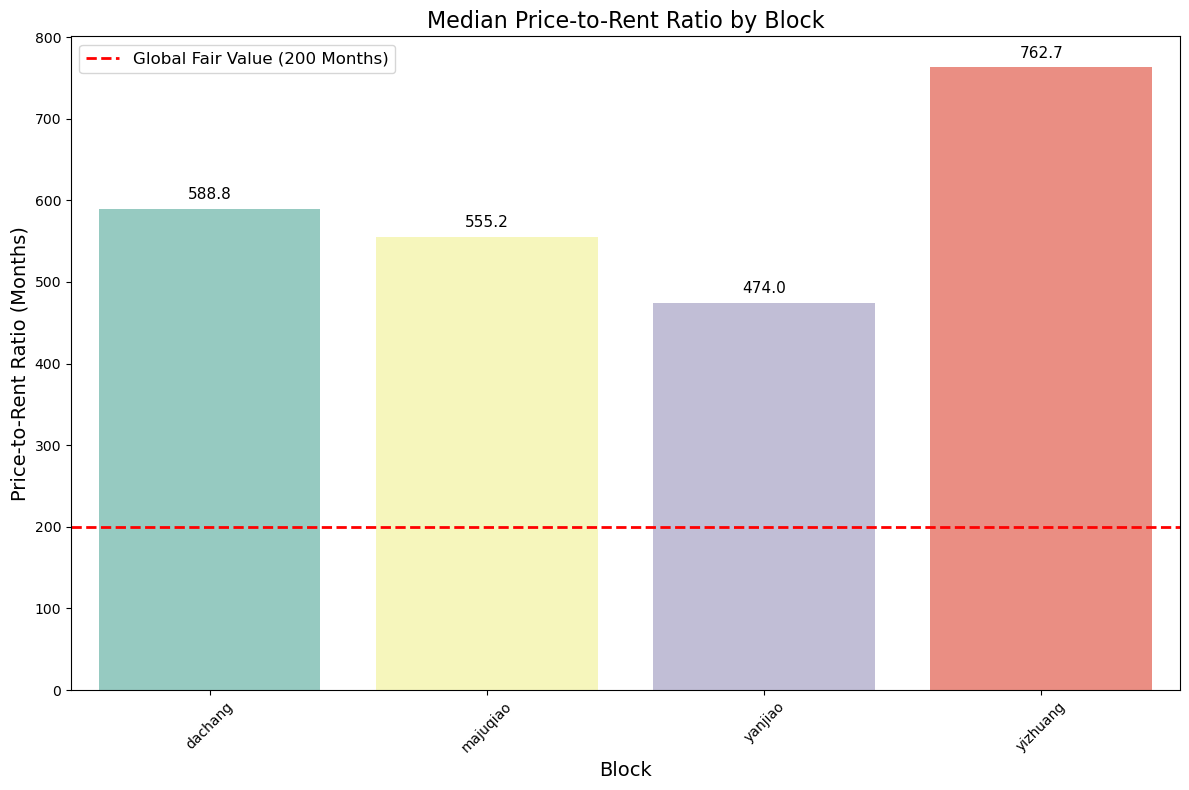


 Price-to-Rent Ratio Results:
      Block  Price-to-Rent Ratio (Months)
0   dachang                         588.8
1  majuqiao                         555.2
2   yanjiao                         474.0
3  yizhuang                         762.7

===== Analysis Conclusion =====


,Block,Price_Median (RMB/㎡),Rent_Median (RMB/㎡/month),Price-to-Rent Ratio (Months)
0,dachang,8558.0,14.535,588.8
1,majuqiao,28374.5,51.110,555.2
2,yanjiao,10532.0,22.220,474.0
3,yizhuang,59664.0,78.230,762.7


In [18]:
def calculate_price_rent_ratio(housing_df, rent_df):
    
    # 4.1 计算各区域中位数（排除异常值影响）
    price_median = housing_df.groupby('Block')['单价'].median().reset_index()
    price_median.columns = ['Block', 'Price_Median (RMB/㎡)']
    
    rent_median = rent_df.groupby('Block')['每平米月租'].median().reset_index()
    rent_median.columns = ['Block', 'Rent_Median (RMB/㎡/month)']
    
    # 4.2 计算房价租金比（月数）= 每平米房价 / 每平米月租
    ratio_df = pd.merge(price_median, rent_median, on='Block')
    ratio_df['Price-to-Rent Ratio (Months)'] = (ratio_df['Price_Median (RMB/㎡)'] / ratio_df['Rent_Median (RMB/㎡/month)']).round(1)
    
    # 4.3 可视化（含全球公允价值参考线200）
    plt.figure(figsize=(12, 8))
    bar_plot = sns.barplot(
        x='Block', 
        y='Price-to-Rent Ratio (Months)', 
        data=ratio_df,
        palette='Set3'
    )
    
    # 添加参考线
    plt.axhline(
        y=200, 
        color='red', 
        linestyle='--', 
        linewidth=2, 
        label='Global Fair Value (200 Months)'
    )
    
    # 标签与数值
    plt.title('Median Price-to-Rent Ratio by Block', fontsize=16)
    plt.xlabel('Block', fontsize=14)
    plt.ylabel('Price-to-Rent Ratio (Months)', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(fontsize=12)
    
    # 在条形上添加数值标签
    for p in bar_plot.patches:
        bar_plot.annotate(
            f'{p.get_height():.1f}',
            (p.get_x() + p.get_width()/2, p.get_height()),
            ha='center', va='bottom',
            xytext=(0, 5), textcoords='offset points',
            fontsize=11
        )
    
    plt.tight_layout()
    plt.savefig('results/figureA_price_rent_ratio_bar.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 4.4 输出分析结论
    print("\n Price-to-Rent Ratio Results:")
    print(ratio_df[['Block', 'Price-to-Rent Ratio (Months)']])
    ratio_df.to_csv('results/price_rent_ratio.csv', index=False)
    
    print("\n===== Analysis Conclusion =====")
   
    
    return ratio_df

calculate_price_rent_ratio(housing_data, rent_data)